## chapter 8 集成学习

### 个体与集成

集成学习通过构建多个学习器（组件学习器：如C4.5、BP神经网络等）来完成学习任务，亦称多分类器系统、基于委员会的学习（某种策略组合起来）等。其往往运用在弱学习器中，并取得显著优越的泛化性能。

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_1.png?raw=true' width=350 align="center">

个体学习器--*好而不同*，即要有一定的准确性，也要有一定的多样性。

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_2.png?raw=true' width=500 align="center">

> 假设T个体学习器的误差相互独立，则根据Hoeffding不等式可知（如下），集成错分率将会随着分类器个数T的增大，呈指数级下降而趋于0.

$$P(H(x) \neq f(x) ) = \sum_{k=0}^{[T/2]} \frac{\Gamma(T)}{\Gamma(k)\Gamma(T-k} (1-\epsilon)^k\epsilon^{T-k} \leq \exp(-\frac{T(1-2\epsilon)^2}{2})$$

**不过在实际任务中，个体学习器是解决同一问题由同一批数据训练出来的，不可能相互独立。**，也即个体学习器的准确性越高，则会牺牲多样性。

 - 个体学习器强依赖、串行生成的序列化方法，如Boosting
 - 个体学习器不存在强依赖、可同时并行化的方法，如Bagging和随机森林。
 

### Boosting

Boosting机制：初始训练后，根据表现对训练样本分布进行调整，使错分的训练样本收到更多关注，然后再持续训练，直到指定的学习器个数T终止。

AdaBoost，可以理解为使指数损失最小的基学习器（$h_t$）的线性组合（加性模型, $f$为真实函数），
$$H(x) = \sum_{t=1}^T\alpha_th_t(x),\qquad l_{exp}(H|D)=E_{x\sim D}[e^{-f(x)H(x)}]$$

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_3.png?raw=true' width=400 align="center">

根据目标函数，对$H(x)$偏导，并求导另为0得:

$$\frac{\partial l_{\exp}(H|D)}{\partial H(x)} = -e^{H(x)} P(f(x)=1|x) + e^{H(x)} P(f(x)=-1|x)$$

$$ sign (H(x)) = sign (\frac{1}{2} \ln \frac{P(f(x)=1|x)}{P(f(x)=-1|x)}) = \arg \max_{y \in \{-1，1\}} P(f(x)=y|x)$$

故$sign (H(x))$ 使得贝叶斯错分率最小，也即说明指数损失函数是分类任务原本0、1损失函数的一致替代，由于其连续可微，所以也常用来作为替代。在AdaBoost中，对应第t次，该基分类器的权重$\alpha_t$ 应使得$\alpha_t h_t$对应的损失函数最小,令错分概率为$\epsilon_t=P_{x\sim D_t} (h_t(x) \neq f(x))$,有权的更新公式：

$$\frac{\partial l_{\exp}(\alpha_t h_t|D_t)}{\partial \alpha_t} = -e^{-\alpha_t} (1-\epsilon_t + e^{\alpha_t} \epsilon_t), \qquad \alpha_t=\frac{1}{2} \ln \frac{1-\epsilon_t}{\epsilon_t}$$

其后，在t-1次的基础上，希望第t次的学习器可以使得分类误差最小化，通过泰勒展开可得：

$$l_{\exp}(H_{t-1}+h_t|D) = E_{x\sim D}[e^{-f(x) (H_{t-1}+h_t)}]=
E_{x\sim D}[e^{-f(x)H_{t-1}(x)} (1 - f(x) h_t(x) + \frac{f^2(x) h_t^2(x)}{2})] 
$$

$$h_t(x) = \arg\min_h l_{\exp}(H_{t-1}+h_t|D) = \arg \max_h E_{x\sim D}[e^{-f(x)H_{t-1}(x)}f(x)h(x)]$$

令$D_t$的分布，则可以求得：

$$D_t(x) = \frac{e^{-f(x) H_{t-1}(x)}}{E_{x\sim D}[e^{-f(x)H_{t-1}(x)}]}
$$
$$h_t(x) = \arg\max_h E_{x\sim D_t}[f(x) h(x)] = \arg\min_h E_{x\sim D_t}[I(f(x)\neq h(x))]$$

由此可见，理想的$h_t$将在分布$D_t$下最小化分类误差，因此，弱分类器将基于分布$D_t$来训练，且针对$D_t$的分类误差应小于0.5， 一定程度上类似于残差逼近的思想，且有训练分布的更新：

$$D_{t+1}(x) = \frac{D(x) e^{-f(x)H_{t-1}(x)} e^{-f(x) \alpha_t h_t(x)}}{E_{x\sim D}[e^{-f(x) H_t(x)}]} = D_t(x) e^{-f(x) \alpha_t h_t(x)} \frac{E_{x\sim D}[e^{-f(x)H_{t-1}(x)}]} {E_{x\sim D}[e^{-f(x)H_t(x)}]}$$

Boosting算法要求基学习器对特定的数据分布进行学习，这也可以通过重赋权法实施，也即每一轮训练中，根据样本分布赋予新的权重，对于无法接受带权样本的，则可以通过重采样来处理。一般来说这两种做法没有显著的优劣差异。但是boosting算法在每一轮中都要检查当前生成的基学习器是否满足基本条件，一旦不满足即被抛弃且停止学习。则此时设置的学习数T还未达到，而导致性能不佳。若采用重采用，则可以重启以避免训练过程过早停止。从方差-偏差分解的角度看，boosting关注降低偏差，也即基于泛化能力弱的学习器构建出很强的集成。



### Bagging

Bagging，基于自助采样，有放回的采和原数据集一样大小的训练集，使得集成中的个体学习器尽可能独立，但同时又有相互交叠的样本，使得训练模型不那么差的同时能够尽可能独立，来提高泛化能力。

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_5.png?raw=true' width=400 align="center">

Bagging计算的复杂度基本与直接使用学习算法训练一个学习器的复杂度同阶，其高效并且不同于Adaboost只适用于二分类任务，能不经修改直接用于多分类或回归等任务中。我们知道自助法值使用初始训练集约三分之二的样本，剩余的可以作为验证集来对泛化能力进行外包估计。

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_21.png?raw=true' width=500 align="center">

包外样本也可以用来辅助剪枝，或是对决策树估计的各个节点的后验概率以修正零；在神经网络中，可以辅助早起停止以减小过拟合，Bagging主要关注降低方差。

### 随机森林

是Bagging的扩展体，不仅保留其对训练样本的采用，而且引入了随机属性选择。与构建一棵树在各个节点处对所有特征选择最优的分割不同，随机森林在一个随机特征集合中，然后进行选择，该集合大小一般是$\log_2 d$(d 为特征个数)。 两重随机性给随机森林带来了更大的多样性，使得最终集成的泛化能力因为个体学习器的差异增大而进一步提升。

### 结合策略

结合的好处：减小单个学习器误选导致的泛化性能降低的风险；降低陷入局部最小的风险；增大相应的假设空间以免不能拟合。

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_8.png?raw=true' width=450 align="center">

#### 平均法

- 简单平均法，个体学习器性能相近时使用
- 加权平均法， 包含简单平均法、权重一般由训练数据中学习得到，但是对于大规模集成来说由于学习的权重比较多易过拟合，未必优于简单平均，所以个体学习器性能相差较大时使用。

#### 投票法

- 绝对多数投票法，超过半数决策，在必须给预测结果时，将退化到相对多数投票法
- 相对多数投票法，多个最高票，随机选取一个
- 加权投票法，加权最大类

需要注意的是不同学习器的类型不同，则其预测值概率不能直接比较，通常转化为类别标记然后在进行投票。

#### 学习法

通过另外一个学习器（次级学习器、元学习器）来结合，如Stacking。

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_9.png?raw=true' width=400 align="center">

为防止过拟合，一般采用交叉验证或者留一法，用训练初级学习器未使用的样本来产生次级学习器的训练样本。选择合适的次级学习器属性与算法对Stacking集成的泛化性能有很大的影响，研究表明多响应线性回归作为次级学习算法效果较好，而使用不同的属性集更加。

贝叶斯模型平均Bayes Model Averaging BMA，基于后验概率来为不同模型赋予新的权重，加权平均的特殊实现。若数据生成模型恰好在考虑中且噪音较小，则BMA不差于Stacking。但是很难用当前的模型近似，因此Stacking会更优，且鲁棒性。

### 多样性

#### 误差-分歧分解

- 分歧ambiguity $\bar A(h|x) = \sum_{i=1}^T w_i(h_i(x)-H(x))^2$
- 个体学习器的加权平均误差 $\bar E(h|x) = \sum_{i=1}^T w_i (f(x)-h_i(x))^2$
- 集成学习器的平法误差 $E(H|x) =(f(x)-H(x))^2$

$$\bar A(h|x) = \sum_{i=1}^T w_i E(h_i|x) - E(H|x) = \bar E(h|x) - E(H|x)$$

上述定义对所有样本成立，若$p(x)$为样本的概率密度，则个体学习器的泛化误差与分歧,集成泛化误差分别为

$$E_i = \int E(h_i|x)p(x)dx, \quad A_i = \int A(h_i|x)p(x)dx,\quad E=\int E(H|x)p(x)dx$$

将个体学习器加权平均可得下： 这表明个体学习器准确性越高，多样性越大则集成效果越好 --- **误差-分歧分解** Error-Ambiguity-Decomposition。这只适用于回归学习，并在现实任务中，很难实现。

$$\bar E=\sum_{i=1}^Tw_iE_i, \quad \bar A=\sum_{i=1}^T w_i A_i ,\qquad E=\bar E- \bar A$$.

#### 多样性度量

给定混淆矩阵

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_c.png?raw=true' width=420 align="center">

- 不合度量（disagreement measure），值越大多样性越大 $dis_{ij}=\frac{b+c}{m}$
- 相关系数 correlation coefficient，$\rho_{ij}=\frac{ad-bc}{\sqrt{(a+b)(a+c)(c+d)(b+d)}}$
- Q-统计量,类似于$\rho_{ij}$, $Q_{ij}=\frac{ad-bc}{ad+bc}$
- $\kappa$-统计量， $\kappa=\frac{p_1-p_2}{1-p_2}$，其中$p_1$是两个分类器一致的概率，$p_2$是两个分类器偶然达成一致的概率。
$$p_1=\frac{a+d}{m},\qquad p_2=\frac{(a+b)(a+c) + (c+d)(b+d)}{m^2}$$

#### 多样性增强

在学习过程中，引入随机性，比如对数据样本、输入属性、输出表示、算法参数进行扰动。

- 数据样本扰动，基于采样，如Bagging采用自助采样、AdaBoost采用序列采样。不同的算法对扰动的敏感性不一样，如决策树、神经网络对数据扰动能有效增加多样性；但是如SVM，k近邻则较为稳定。

- 输入属性扰动， 不同子空间提供观察数据的不同视角。一方面可以去除冗余属性，较少开销，同时产生多样性大的个体。当属性较少时不宜使用。

<img src='https://github.com/ZRChao/Book-reading/blob/master/周志华西瓜书/figures/8_11.png?raw=true' width=380 align="center">

- 输出表示扰动，例如对训练样本的类标稍作变得，如翻转法随机改变一些训练样本的标记；输出调制法，将分类输出转化为回归输出；将原任务拆分多个可同时求解的子任务，如ECoC法。

- 算法参数扰动，例如神经网络，随机设置不同参数，可以产生差别较大的个体学习器。例如**负相关法**，显示的通过正则化来强制个体神经网络使用不同的参数。说明，单一学习器一般通过交叉验证选择最优参数模型，这里已经训练了多个学习器而只选择一个，但是集成学习则是进行综合，故集成的实际计算开销并不比单一学习器大很多。

### 阅读材料
### 习题

Automatically created module for IPython interactive environment


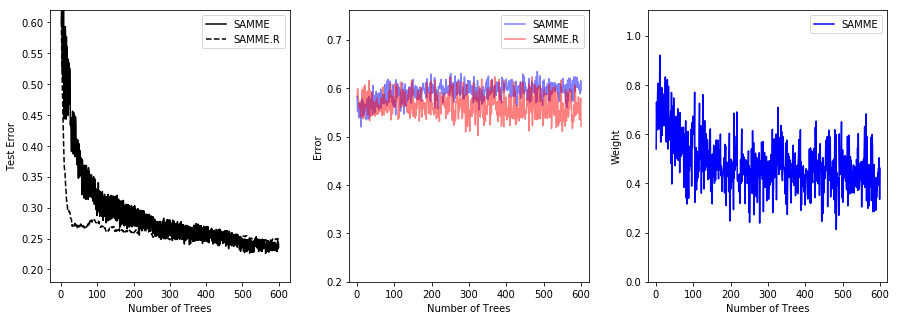

In [3]:
print(__doc__)

# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


X, y = make_gaussian_quantiles(n_samples=13000, n_features=10,
                               n_classes=3, random_state=1)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()